this is an demonstration and learning for the time series modeling for cryptocurrency
https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/
multiple forecasting techniques will be deployed here. and compare them by implementing on a dataset. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_all=pd.read_csv("D:/python-ml/kaggles_competition/StoreItermForecast/TS-dataset/train.csv")
print (df_all.shape)
df_all.head()

(18288, 3)


,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


Understanding the Problem Statement and Dataset.

We are provided with a Time Series problem involving prediction of number of commuters of JetRail, 
a new high speed rail service by Unicorn Investors. We are provided with 2 years of data(Aug 2012-Sept 2014) 
and using this data we have to forecast the number of commuters for next 7 months.

As seen from the print statements above, we are given 2 years of data(2012-2014) at hourly level with 
the number of commuters travelling and we need to estimate the number of commuters for future.


In [2]:
df_all.tail()

,ID,Datetime,Count
18283,18283,25-09-2014 19:00,868
18284,18284,25-09-2014 20:00,732
18285,18285,25-09-2014 21:00,702
18286,18286,25-09-2014 22:00,580
18287,18287,25-09-2014 23:00,534


In this article, I’m subsetting and aggregating dataset at daily basis to explain the different methods.

Subsetting the dataset from (August 2012 – Dec 2013);

Creating train and test file for modeling. The first 14 months (August 2012 – October 2013) are used
as training data and next 2 months (Nov 2013 – Dec 2013) as testing data.

Aggregating the dataset at daily basis

In [3]:
#Subsetting the dataset
#Index 11856 marks the end of year 2013
df = pd.read_csv('D:/python-ml/kaggles_competition/StoreItermForecast/TS-dataset/train.csv', nrows = 11856)

#Creating train and test set 
#Index 10392 marks the end of October 2013 
train=df[0:10392] 
test=df[10392:]

#Aggregating the dataset at daily level
timestamp = pd.to_datetime(df.Datetime,format='%d-%m-%Y %H:%M') 
df.index=pd.DatetimeIndex(timestamp)
df = df.resample('D').mean() # resample the data using calender day frequency, and use the mean value. 
df.head()

timestamp1=pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
train.index=pd.DatetimeIndex(timestamp1)
train=train.resample('D').mean()

timestamp2=pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M')
test.index=pd.DatetimeIndex(timestamp2)
test=test.resample('D').mean()
test.head()

,ID,Count
Datetime,,
2013-11-01,10403.5,161.583333
2013-11-02,10427.5,103.083333
2013-11-03,10451.5,76.833333
2013-11-04,10475.5,156.416667
2013-11-05,10499.5,169.750000


Let’s visualize the data (train and test together) to know how it varies over a time period

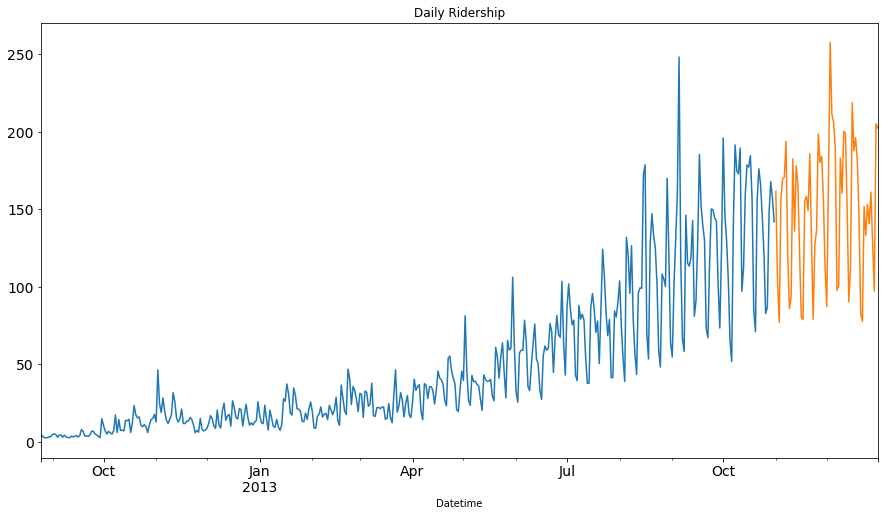

In [4]:
plt.figure(figsize=(15,8))
train['Count'].plot(title= 'Daily Ridership', fontsize=14)
test['Count'].plot(title='Daily Ridership',fontsize=14)

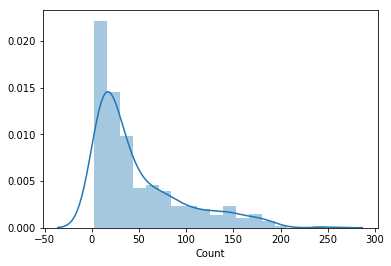

In [5]:
import seaborn as sns
sns.distplot(train.Count)

# Table of Contents
Understanding the Problem Statement and Dataset
Installing library (statsmodels)
Method 1 – Start with a Naive Approach
Method 2 – Simple average
Method 3 – Moving average
Method 4 – Single Exponential smoothing
Method 5 – Holt’s linear trend method
Method 6 – Holt’s Winter seasonal method
Method 7 – ARIMA

# Method 1: Start with a Naive Approach
    
Consider the graph given below. Let’s assume that the y-axis 
depicts the price of a coin and x-axis depicts the time (days).

We can infer from the graph that the price of the coin is stable from the start. Many a times we are provided with a dataset, which is stable throughout it’s time period. If we want to forecast the price for the next day, we can simply take the last day value and estimate the same value for the next day. Such forecasting technique which assumes that the next expected point is equal to the last observed point is called Naive Method.

$\bar{y}_{t+1}=y_{t}$

Now we will implement the Naive method to forecast the prices for test data.

                 ID       Count  naive
Datetime                              
2013-11-01  10403.5  161.583333  142.0
2013-11-02  10427.5  103.083333  142.0
2013-11-03  10451.5   76.833333  142.0
2013-11-04  10475.5  156.416667  142.0
2013-11-05  10499.5  169.750000  142.0


Text(0.5, 1.0, 'Naive Forecast')

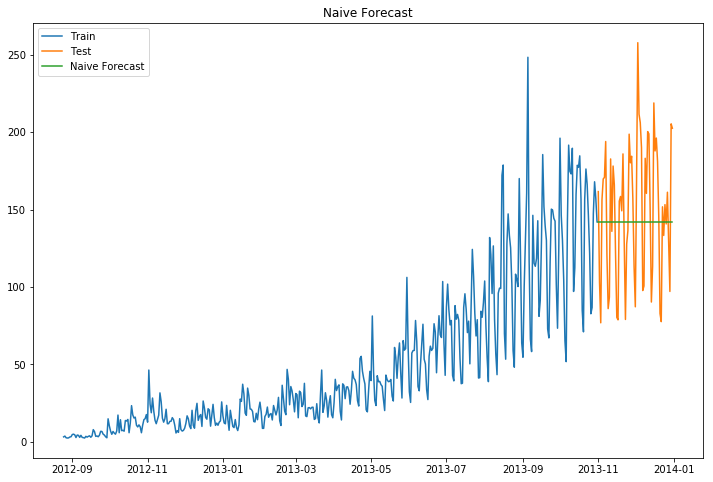

In [6]:
dd= np.asarray(train.Count) # creat an array with the same shape as Series : train.Count 
y_hat = test.copy()  # series for prediction 
y_hat['naive'] = dd[len(dd)-1] # predicted value with the value from the former day. 
print (y_hat.head())

plt.figure(figsize=(12,8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index,test['Count'], label='Test')


plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")

We will now calculate RMSE to check to accuracy of our model on test data set.

In [7]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms=sqrt(mean_squared_error(test.Count,y_hat.naive))  #  mean_squared_error(true value, predicted value)
print(rms)


43.91640614391676


We can infer from the RMSE value and the graph above, that Naive method isn’t suited for 
datasets with high variability. It is best suited for stable datasets. We can still 
improve our score by adopting different techniques. 
Now we will look at another technique and try to improve our score.

# Method 2: – Simple Average
Consider the graph given below. Let’s assume that the y-axis depicts 
the price of a coin and x-axis depicts the time(days).

We can infer from the graph that the price of the coin is increasing and decreasing randomly by a small margin, 
such that the average remains constant. 
Many a times we are provided with a dataset, 
which though varies by a small margin throughout it’s time period, but the average at each time period remains constant. In such a case we can forecast the price of the next day somewhere similar to the average of all the past days.

Such forecasting technique which forecasts the expected value equal to the average of
all previously observed points is called Simple Average technique.


$\bar{y}_{x+1}=\frac{1}{x}sum(y_i)$

We take all the values previously known, calculate the average and take it as the next value. Of course 
it won’t be it exact, but somewhat close. As a forecasting method, there are 
actually situations where this technique works the best.

                 ID       Count  avg_forecast
Datetime                                     
2013-11-01  10403.5  161.583333     48.333718
2013-11-02  10427.5  103.083333     48.333718
2013-11-03  10451.5   76.833333     48.333718
2013-11-04  10475.5  156.416667     48.333718
2013-11-05  10499.5  169.750000     48.333718


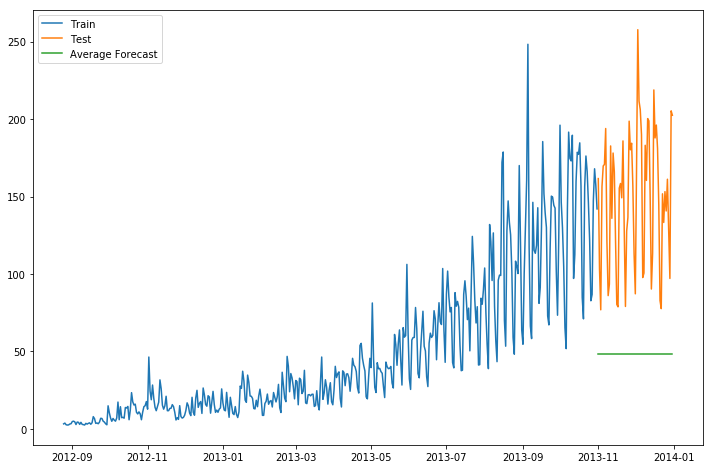

In [8]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Count'].mean()
print (y_hat_avg.head())

plt.figure(figsize=(12,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')



In [9]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.avg_forecast))
print (rms)

109.88526527082863


We can see that this model didn’t improve our score. Hence we can infer 
from the score that this method works best when the average at each time period remains 
constant. Though the score of Naive method is better than Average method, 
but this does not mean that the Naive method is better than Average method on all datasets. We should move step 
by step to each model and confirm whether it improves our model or not.

# Method 3 – Moving Average
Consider the graph given below. Let’s assume that the y-axis depicts the price 
of a coin and x-axis depicts the time(days).

We can infer from the graph that the prices of the coin increased some time periods ago by a big margin but now they are stable. Many a times we are provided with a dataset, in which the prices/sales of the object increased/decreased sharply some time periods ago. In order to use the  previous Average method, we have to use the mean of all the previous data, but using all the previous data doesn’t sound right.

Using the prices of the initial period would highly affect the forecast for the next period. Therefore as an improvement over simple average, we will take the average of the prices for last few time periods only. Obviously the thinking here is that only the recent values matter. Such forecasting technique which uses window of time period for calculating the average is called Moving Average technique. Calculation of the moving average involves what is sometimes called a “sliding window” of size n.

Using a simple moving average model, we forecast the next value(s) in a time series based on the average of a fixed finite number ‘p’ of the previous values. Thus, for all i > p

$\bar{Y}_{x+1}=\frac{1}{p}(Y_{i-1}+Y_{i-2}+Y_{i-3}+...+Y_{i-p})$
A moving average can actually be quite effective, especially if you pick the right p for the series

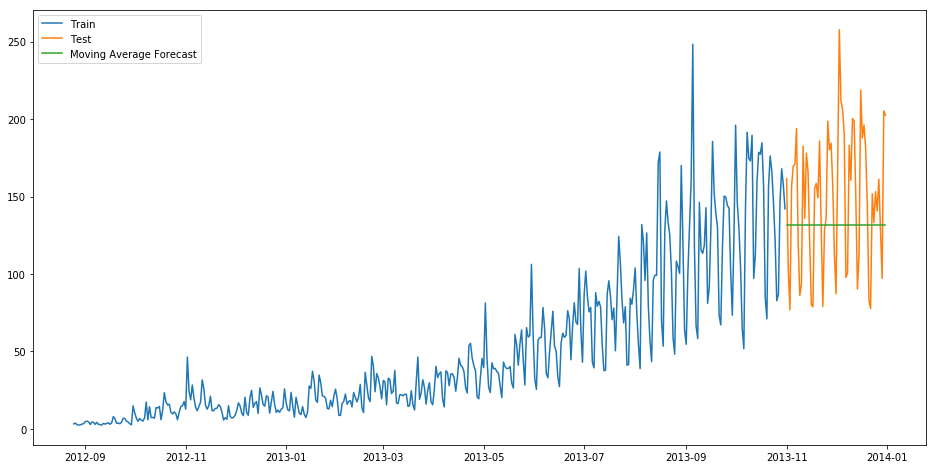

In [10]:
y_hat_avg = test.copy()
# choose the average value of each 60 elements in training dataset
train_avg=train['Count'].rolling(60).mean()
y_hat_avg['moving_avg_forecast'] = train_avg.iloc[-1] # select the last average value.  

train_avg.tail()

plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [43]:
train_avg.tail()

Datetime
2013-10-27    128.333333
2013-10-28    127.955556
2013-10-29    128.747222
2013-10-30    130.304167
2013-10-31    131.761111
Freq: D, Name: Count, dtype: float64

In [11]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.moving_avg_forecast))
print(rms)

46.72840725106963


We can see that Naive method outperforms both Average method and Moving Average method for this dataset. 
Now we will look at Simple Exponential Smoothing method and see how it performs.

An advancement over Moving average method is Weighted moving average method. In the Moving average method as 
seen above, we equally weigh the past ‘n’ observations. But we might encounter situations where each of the 
observation from the past ‘n’ impacts the forecast in a different way. 
Such a technique which weighs the past observations differently is called Weighted Moving Average technique.

A weighted moving average is a moving average where within the sliding window values are given different weights, 
typically so that more recent points matter more. Instead of selecting a window size,
it requires a list of weights (which should add up to 1). 
For example if we pick [0.40, 0.25, 0.20, 0.15] as weights, 
we would be giving 40%, 25%, 20% and 15% to the last 4 points respectively.

# Method 4 – Simple Exponential Smoothing

After we have understood the above methods, we can note that both Simple average and
Weighted moving average lie on completely opposite ends. We would need something
between these two extremes approaches which takes into account all the data 
while weighing the data points differently. For example it may be sensible to 
attach larger weights to more recent observations than to observations from the 
distant past. The technique which works on this principle is called Simple exponential smoothing. 
Forecasts are calculated using weighted averages where the weights decrease exponentially
as observations come from further in the past, the smallest weights are associated with the 
oldest observations:

$\bar{Y}_{T+1/T}=\alpha Y_T+\alpha (1-\alpha) Y_{T-1}+\alpha (1-\alpha)^2Y_{T-2}+...$

where $0≤ \alpha ≤1$ is the smoothing parameter.

The one-step-ahead forecast for time T+1 is a weighted average of all the observations 
in the series y1,…,yT. The rate at which the weights decrease is controlled by the parameter $ \alpha $.

If you stare at it just long enough, you will see that the expected value ŷx is the sum of two products: 
$ \alpha Y_T$ and $(1− \alpha )\bar{Y}_{T-1}$.

Hence, it can also be written as :

$\bar{Y}_{T+1/T}=\alpha Y_T+(1-\alpha)\bar{Y}_{T|T-1}$


So essentially we’ve got a weighted moving average with two weights: $\alpha$ and $1−\alpha$.

As we can see, $1−\alpha$ is multiplied by the previous expected value $\bar{Y}_{T|T-1}$ which makes the expression recursive. And this is why this method is called Exponential. The forecast at time t+1 is equal to a weighted average between the most recent observation $y_t$ and the most recent forecast $\bar{Y}_{T|T-1}$.

Note: this is acturally a recusive problem, we can use the Dynamic programming algorithm to solve it. 

when $\alpha=0$: the forecasts of all future values are equal to the average (or “mean”) of the historical data, which is called Average method.

when $\alpha=1$: imply set all forecasts to be the value of the last observation, which is called Naive method in statistics.

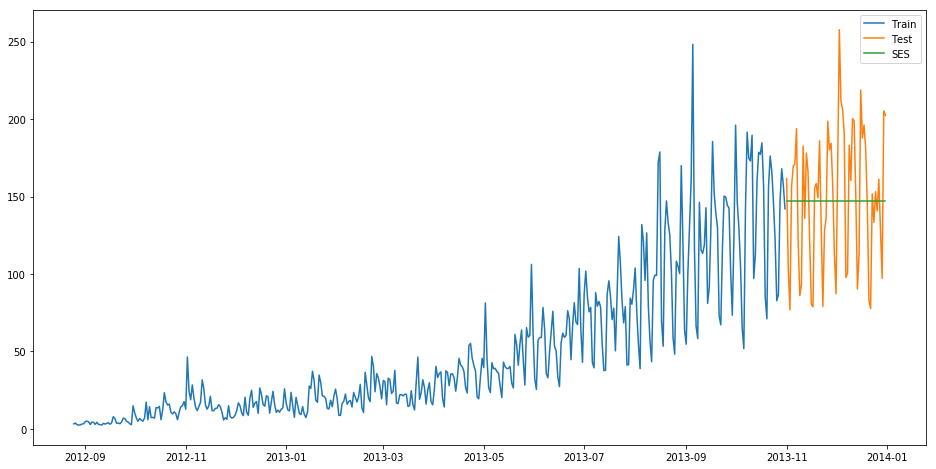

In [12]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

y_hat_avg = test.copy() # a copy of test dataset

fit2 = SimpleExpSmoothing(np.asarray(train['Count'])).fit(smoothing_level=0.6,optimized=False) # alpha=0.6, array-like 
# time series.
# the length of the forecast data should be defined. Here, 
# the length of parameter should match the length of index in predict pandas data. otherwise, error !
y_hat_avg['SES'] = fit2.forecast(len(test)) # predicted value based on the length of all test data.


plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')


In [13]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.SES))
print(rms)

43.357625225228155


We can see that implementing Simple exponential model with alpha as 0.6 generates a better model till now. 
We can tune the parameter using the validation 
set to generate even a better Simple exponential model.

# Method 5 – Holt’s Linear Trend method
We have now learnt several methods to forecast but we can see that these models don’t work
well on data with high variations. 
Consider that the price of the bitcoin is increasing.

If we use any of the above methods, it won’t take into account this trend. Trend is the general pattern of prices that we observe over a period of time. In this case we can see that there is an increasing trend.

Although each one of these methods can be applied to the trend as well.  E.g. the Naive method would assume that trend between last two points is going to stay the same, or we could average all slopes between all points to get an average trend, use a moving trend average or apply exponential smoothing.

But we need a method that can map the trend accurately without any assumptions. Such a method that takes into account the trend of the dataset is called Holt’s Linear Trend method.

 ## Trend, Seasonality and Residual

Each Time series dataset can be decomposed into it’s componets which are Trend,Seasonality and Residual. Any dataset that follows a trend can use Holt’s linear trend method for forecasting.

<Figure size 1152x432 with 0 Axes>

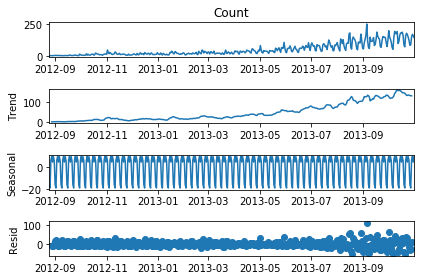

In [20]:
import statsmodels.api as sm
plt.figure(figsize=(16,6))
sm.tsa.seasonal_decompose(train.Count).plot()
result = sm.tsa.stattools.adfuller(train.Count)
plt.show()

We can see from the graphs obtained that this dataset follows an increasing trend. Hence we can use Holt’s linear 
trend to forecast the future prices.

Holt extended simple exponential smoothing to allow forecasting of data with a trend. 
It is nothing more than exponential smoothing applied to both level(the average value in the series) and trend. 
To express this in mathematical notation we now need three equations: one for level, 
one for the trend and one to combine the level and trend to get the expected forecast $\bar{y}$:

forecast equation : $\bar{Y}_{t+h|t}=l_t+hb_t$

Level equation :   $l_t=\alpha Y_t +(1-\alpha) (l_{t-1}+b_{t-1})$

Trend equation : $b_t= \beta^* (l_t-l_{t-1})+(1-\beta^*)b_{t-1}$

where  $l_t$ denotes an estimate of the level of the series at time  t, $b_t$ denotes an estimate of the trend (slope) of the series at time t, $\alpha$ is the smoothing parameter for the level,  $1<=\alpha<=1$, and $\beta^*$ is the smoothing parameter for the trend, $1<=\beta<=1$. (We denote this as  $\beta^8$, instead of $\beta$ for reasons that will be explained further. 


As with simple exponential smoothing, the level equation here shows that  $l_t$ is a weighted average of observation  
$y_t$, and the one-step-ahead training forecast for time  t, here given by  $(l_{t-1}+b_{t-1})$.

The trend equation shows that  $b_t$ is a weighted average of the estimated trend at time t based on  $(l_t-l_{t-1})$
and $b_{t-1}$, the previous estimate of the trend.

The forecast function is no longer flat but trending. The  $h$ -step-ahead forecast is equal to the last estimated level plus  $h$ times the last estimated trend value. Hence the forecasts are a linear function of  $h$.

c:\python 35\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


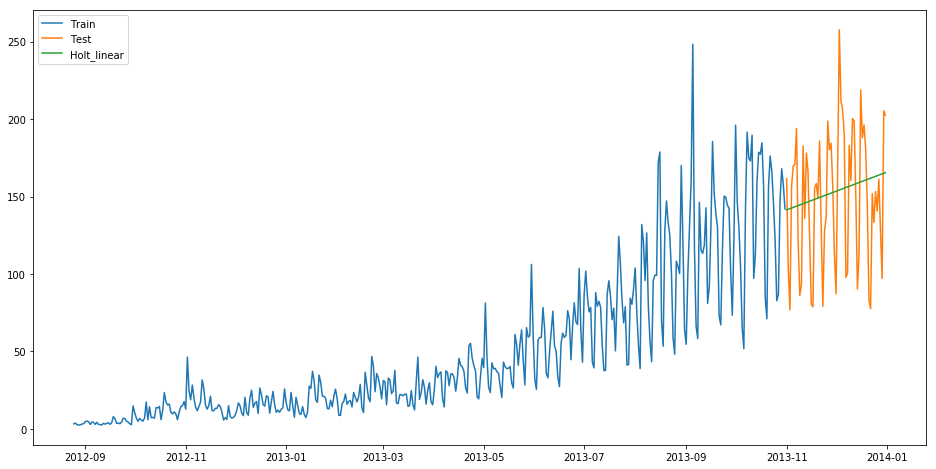

In [22]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()

# np.asarray(): return an array but directly modify the original data, instead of a copy. 
fit1 = Holt(np.asarray(train['Count'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1) # Holt's linear model 
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

y_hat_avg.head()
plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [16]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.Holt_linear))
print(rms)

43.056259611507286


We can see that this method maps the trend accurately and hence provides a better solution when compared 
with above models. 
We can still tune the parameters to get even a better model.

# Method 6 – Holt-Winters Method
So let’s introduce a new term which will be used in this algorithm. Consider a hotel located on a hill station. 
It experiences high visits during the 
summer season whereas the visitors during the rest of the year are comparatively very less. 
Hence the profit earned by the owner will be far better in summer season than in any other season. 
This pattern will repeat itself every year. Such a repetition is called Seasonality. 
Datasets which show a similar set of pattern after fixed intervals of a time period suffer from seasonality.

The above mentioned models don’t take into account the seasonality of the dataset while forecasting. Hence we need a method that takes into account both trend and seasonality to forecast future prices. One such algorithm that we can use in such a scenario is Holt’s Winter method. The idea behind triple exponential smoothing(Holt’s Winter) is to apply exponential smoothing to the seasonal components in addition to level and trend.

Using Holt’s winter method will be the best option among the rest of the models beacuse of the seasonality factor. The Holt-Winters seasonal method comprises the forecast equation and three smoothing equations — one for the level ℓt, one for trend bt and one for the seasonal component denoted by st, with smoothing parameters α, β and γ.

level: $L_t=\alpha (y_t-S_{t-s})+(1-\alpha)(L_{t-1}+b_{t-1})$

trend: $b_t=\beta(L_t-L_{t-1})+(1-\beta)(b_{t-1})$

seasonal :  $s_t=\gamma(y_t-L_t)+(1-\gamma)s_{t-s}$

Forecast:  $\bar{F}_{t+k}=L_t+kb_t+S_{t+k-s}$



where s is the length of the seasonal cycle, for 0 ≤ α ≤ 1, 0 ≤ β ≤ 1 and 0 ≤ γ ≤ 1.

The level equation shows a weighted average between the seasonally adjusted observation and the non-seasonal forecast for time t. The trend equation is identical to Holt’s linear method. The seasonal equation shows a weighted average between the current seasonal index, and the seasonal index of the same season last year (i.e., s time periods ago).

 

In this method also, we can implement both additive and multiplicative technique.  The additive method is preferred when the seasonal variations are roughly constant through the series, while the multiplicative method is preferred when the seasonal variations are changing proportional to the level of the series.

c:\python 35\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
c:\python 35\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
c:\python 35\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


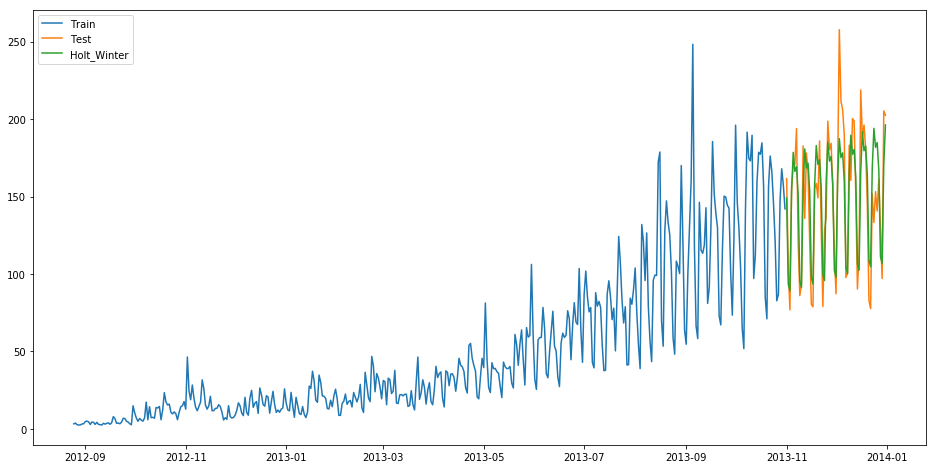

In [38]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Count']),seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))


plt.figure(figsize=(16,8))
plt.plot( train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [33]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.Holt_Winter))
print(rms)


23.961492566159794


We can see from the graph that mapping correct trend and seasonality provides a far better solution. 
We chose seasonal_period = 7 as data repeats itself weekly. Other parameters can be tuned as per the dataset.
I have used default parameters while building this model. 
You can tune the parameters to achieve a better model.

# Method 7 – ARIMA
Another common Time series model that is very popular among the Data scientists is ARIMA. 
It stand for Autoregressive Integrated Moving average. While exponential smoothing models were based on 
a description of trend and seasonality in the data, ARIMA models aim to describe the correlations in the data with 
each other. An improvement over ARIMA is Seasonal ARIMA. It takes into account the seasonality of dataset just 
like Holt’ Winter method. 
You can study more about ARIMA and Seasonal ARIMA models and it’s pre-processing from these articles (1) and (2).

c:\python 35\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


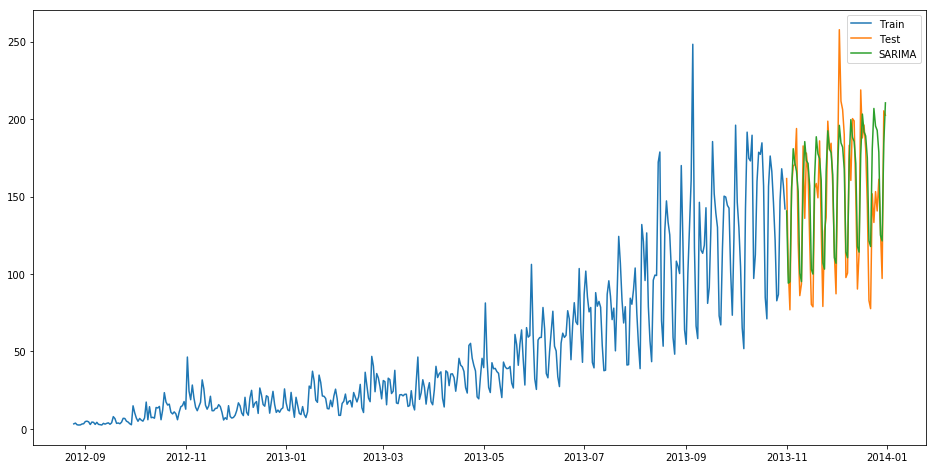

In [39]:
y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train.Count, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2013-11-1", end="2013-12-31", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

In [40]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.SARIMA))
print(rms)

26.037341512974407


We can see that using Seasonal ARIMA generates a similar solution as of Holt’s Winter. We chose the parameters as per the ACF and PACF graphs. You can learn more about them from the links provided above. If you face any difficulty finding the parameters of ARIMA model, you can use auto.arima implemented in R language. A substitute of auto.arima in Python can be viewed here.

# End Notes
I hope this article was helpful and now you’d be comfortable in solving similar Time series problems. I suggest you take different kinds of problem statements and take your time to solve them using the above-mentioned techniques. Try these models and find which model works best on which kind of Time series data.

One lesson to learn from these steps is that each of these models can outperform others on a particular dataset. Therefore it doesn’t mean that one model which performs best on one type of dataset will perform the same for all others too.

You can also explore forecast package built for Time series modelling in R language. You may also explore Double seasonality models from forecast package. Using double seasonality model on this dataset will generate even a better model and hence a better score.